In [3]:
!pip install git+https://github.com/openai/CLIP.git
!wget https://people.eecs.berkeley.edu/~efros/img/Efros__photo_Peter_Badge_crop.jpg
!mv Efros__photo_Peter_Badge_crop.jpg efros.jpg

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-uutun5j5
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-uutun5j5
  Resolved https://github.com/openai/CLIP.git to commit 573315e83f07b53a61ff5098757e8fc885f1703e
--2021-12-01 13:00:59--  https://people.eecs.berkeley.edu/~efros/img/Efros__photo_Peter_Badge_crop.jpg
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 456031 (445K) [image/jpeg]
Saving to: ‘Efros__photo_Peter_Badge_crop.jpg’

Efros__photo_Peter_ 100%[===================>] 445.34K  --.-KB/s    in 0.02s   

2021-12-01 13:00:59 (26.3 MB/s) - ‘Efros__photo_Peter_Badge_crop.jpg’ saved [456031/456031]



In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
!nvidia-smi

Thu Dec  9 21:02:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA Quadro R...  On   | 00000000:1A:00.0 Off |                  Off |
| 33%   54C    P2   242W / 260W |  22852MiB / 24220MiB |     97%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA Quadro R...  On   | 00000000:1B:00.0 Off |                  Off |
| 33%   

In [2]:
%load_ext autoreload
%autoreload 2
from __future__ import annotations

In [3]:
import copy
import os
from time import perf_counter
import click
import imageio
import numpy as np
import PIL.Image
import torch
import torch.nn.functional as F
import einops

import dnnlib
import legacy

from projector import *

from metrics.frechet_inception_distance import compute_fid_diffusion_vs_dataset, compute_fid_gaussian_vs_dataset
from metrics.kernel_inception_distance import compute_kid_projector
from metrics.metric_utils import MetricOptions, MetricOptionsDiffusion, MetricOptionsDistribution, MetricOptionsProjector

/home/oleksiiv/anaconda3/envs/ganenvem1/lib/python3.9/site-packages/clip/clip.py:23: UserWarning: PyTorch version 1.7.1 or higher is recommended
  warnings.warn("PyTorch version 1.7.1 or higher is recommended")


In [6]:
def create_video(projected_w_steps, projector, num_rows=1, outdir="out", name="test.mp4"):
    # Render debug output: optional video and projected image and W vector.
    os.makedirs(outdir, exist_ok=True)
    with torch.no_grad():
        video = imageio.get_writer(f'{outdir}/{name}', mode='I', fps=10, codec='libx264', bitrate='8M')
        print (f'Saving optimization progress video {outdir}/{name}')
        frame_count = 0
        

        for projected_w in projected_w_steps:
            frame_count += 1
            if projected_w_steps.shape[0] < 500 or frame_count % 10 == 0:
                synth_image = projector.gen.latent_to_image(projected_w)
                synth_image = (synth_image + 1) * (255/2)
                synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8).cpu().numpy()
                grid_image = einops.rearrange(synth_image, "(n1 n2) h w c-> (n1 h) (n2 w) c", n1=num_rows)
                video.append_data(grid_image)
                # video.append_data(np.concatenate([target_uint8, synth_image], axis=1))
        video.close()
def save_image(w, projector, num_rows=1, outdir="out", name="test.png"):
    os.makedirs(outdir, exist_ok=True)
    print (f'Saving image {outdir}/{name}')
    with torch.no_grad():
        synth_image = projector.gen.latent_to_image(w)
        synth_image = (synth_image + 1) * (255/2)
        synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8).cpu().numpy()
        grid_image = einops.rearrange(synth_image, "(n1 n2) h w c-> (n1 h) (n2 w) c", n1=num_rows)
        plt.imsave(f'{outdir}/{name}.png', grid_image)

In [7]:
# network_pkl = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
network_pkl = "https://nvlabs-fi-cdn.nvidia.com/stylegan2/networks/stylegan2-car-config-f.pkl"
target_fname = "efros.jpg"
outdir = "out"
save_video = True
seed = 203
np.random.seed(seed)
torch.manual_seed(seed)
num_steps = 200
device = torch.device('cuda')

In [8]:
generator = Generator(network_pkl, normalize_latent="all_dims", device=device, latent_space="style")
# generator = Generator(network_pkl, device=device, latent_space="style")

Setting up PyTorch plugin "bias_act_plugin"... Done.
Normalizing across all channels.


In [ ]:
target = (generator.latent_to_image(generator.sample_latent(1))*127.5 + 128).detach().clamp(0, 255).to(torch.uint8)[0]

In [44]:
samples = (generator.latent_to_image(generator.sample_latent(16))*127.5 + 128).detach().clamp(0, 255).to(torch.uint8)
num_rows = 4
grid_image = einops.rearrange(samples.permute(0, 2, 3, 1).cpu().numpy(), "(n1 n2) h w c-> (n1 h) (n2 w) c", n1=num_rows)
plt.imsave("samples.png", grid_image)
prior = Prior(generator, device=device, prior_type='cluster', regularize_cluster_weight=1, num_clusters=4)# clusters.shape

running k-means on cuda..


[running kmeans]: 0it [00:00, ?it/s]

KeyboardInterrupt: 

In [7]:
target = torch.tensor(plt.imread("target2.png")[:, :, :3]*255).to(torch.uint8).permute(2, 0, 1).to(device)
# target.min()
# plt.imsave("target2.png", target.permute(1, 2, 0).cpu().numpy())

torch.Size([3, 512, 512])

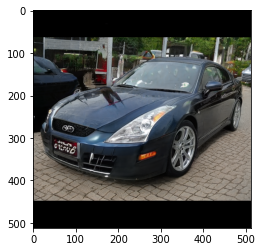

In [8]:
plt.imshow(target.permute(1, 2, 0).cpu().numpy())
target.shape

# test different samples
# 

In [9]:
# prior = Prior(generator, device=device, prior_type='cluster', regularize_cluster_weight=1, num_clusters=18)

In [9]:
# prior = DiffusionPrior(device=device, hidden_h=8960, hidden_dim=10240, num_hidden=5, normalize=True)
prior = DiffusionPrior(device=device)
prior.load_network("/home/oleksiiv/logs/ominous-wraith-125/epoch_2000_ckpt.pth")
# prior.load_network("/home/oleksiiv/logs/giddy-mountain-154/most_recent_ckpt.pth")


# prior = Prior(generator, device=device, prior_type='l2', regularize_w_l2=1)

# target = torch.cat((torch.zeros(2, 512, 512), 255*torch.ones(1, 512, 512)), 0)
# task = Task(device=device, target=target)
# task = Task(device=device, task_type = 'clip_text', target_str = 'racecar')

mask = torch.tensor(np.concatenate((np.zeros((3, 256, 512)), np.ones((3, 256, 512))), axis =1))
plt.imsave("mask.png", mask.permute(1, 2, 0).cpu().numpy())
task = Task(device=device, target=target, task_type = "perceptual_inpainting", mask = mask) # lr = 10
# task = Task(device=device, target=target, task_type = "inpainting", mask = mask)
projector = Projector(generator, task, prior=prior, device=device)


Using group norm group size = 32.
<All keys matched successfully>


In [21]:
mask = torch.tensor(np.concatenate((np.zeros((3, 256, 512)), np.ones((3, 256, 512))), axis =1))
plt.imsave("mask.png", mask.permute(1, 2, 0).cpu().numpy())

In [23]:
mask = torch.tensor(plt.imread("mask.png")[:, :, :3]).to(torch.uint8).permute(2, 0, 1).to(device)

In [25]:
mask.min()
python project_latent.py --latent_space style --target_fname target2.png --out_dir out12 --prior_type l2 --lr 0.01 --num_img 18 --num_steps 1000 --prior_weight 0.0001 --mask_fname mask.png
python project_latent.py --latent_space style --target_fname target2.png --out_dir out12 --prior_type l2 --lr 0.01 --num_img 18 --num_steps 1000 --prior_weight 0.00005 --mask_fname mask.png
python project_latent.py --latent_space style --target_fname target2.png --out_dir out12 --prior_type l2 --lr 0.01 --num_img 18 --num_steps 1000 --prior_weight 0.00001 --mask_fname mask.png
python project_latent.py --latent_space style --target_fname target2.png --out_dir out12 --prior_type l2 --lr 0.01 --num_img 18 --num_steps 1000 --prior_weight 0.000005 --mask_fname mask.png
python project_latent.py --latent_space style --target_fname target2.png --out_dir out12 --prior_type l2 --lr 0.01 --num_img 18 --num_steps 1000 --prior_weight 0.000001 --mask_fname mask.png

tensor(0, device='cuda:0', dtype=torch.uint8)

In [10]:

lr = 0.3
num_img = 12

init_t = 0.05
d = 0
mode = "mini_end"
lamb = 2

# later TODO mem optimization -> mixed precision, gradient checkpointing, multiGPU 
projected_w_steps = projector.project_batched(
    num_img,
    6, # batch size -> depends on gpu
    learning_rate=lr,
    num_steps=100,
    # diffusion_time_schedule=mode,
    num_diffusion_steps_per_step = d,
    # diffusion_step_size = s,
    mini_end_init_t = init_t,
    diffusion_magnitude_lambda = lamb,
    # optimizer_step = True,
    # save_video=True,
    # prior_loss_weight = 0,
)

save_image(projected_w_steps, projector, num_rows=4, outdir="out12", name="god")

# z, bpd = prior.ode_likelihood(projected_w_steps.detach()[:, :, None, :], eps=1e-6)
# idxs = np.argsort(bpd.cpu().numpy())
# ll_w_steps = projected_w_steps[idxs]
# save_image(ll_w_steps, projector, num_rows=5, outdir="out10", name="cluster_prior1")

# create_video(projected_w_steps, projector, num_rows=4, outdir="out13", name=f"lol.mp4")

  0%|                                                                                                                                                                                                                   | 0/2 [00:00<?, ?it/s]

Setting up PyTorch plugin "upfirdn2d_plugin"... 


  1%|██                                                                                                                                                                                                       | 1/100 [00:00<01:23,  1.19it/s]

Done.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:03<00:00, 31.52s/it]


Saving image out12/god


In [20]:

lr = 0.3
num_img = 6

init_t = 0.05
d = 20
mode = "mini_end"
lamb = 2

# later TODO mem optimization -> mixed precision, gradient checkpointing, multiGPU 
projected_w_steps = projector.project(
    num_images=num_img,
    learning_rate=lr,
    num_steps=200,
    # diffusion_time_schedule=mode,
    num_diffusion_steps_per_step = d,
    # diffusion_step_size = s,
    mini_end_init_t = init_t,
    diffusion_magnitude_lambda = lamb,
    optimizer_step = True,
    save_video=True,
    # prior_loss_weight = 0,
)

# save_image(projected_w_steps, projector, num_rows=4, outdir="out12", name="god")

# z, bpd = prior.ode_likelihood(projected_w_steps.detach()[:, :, None, :], eps=1e-6)
# idxs = np.argsort(bpd.cpu().numpy())
# ll_w_steps = projected_w_steps[idxs]
# save_image(ll_w_steps, projector, num_rows=5, outdir="out10", name="cluster_prior1")

create_video(projected_w_steps, projector, num_rows=3, outdir="out13", name=f"lol2.mp4")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:49<00:00,  1.83it/s]


Saving optimization progress video out13/lol2.mp4


In [ ]:

init_t = 0.05
lr = 0.01
d = 10
mode = "mini_end"
num_img = 30
lamb = 2

# later TODO mem optimization -> mixed precision, gradient checkpointing, multiGPU 
projected_w_steps = projector.project_batched(
    num_img,
    6, # batch size -> depends on gpu
    learning_rate=lr,
    num_steps=100,
    diffusion_time_schedule=mode,
    num_diffusion_steps_per_step = d,
    # diffusion_step_size = s,
    mini_end_init_t = init_t,
    diffusion_magnitude_lambda = lamb,
    # optimizer_step = True,
    # prior_loss_weight = 0.01,
)

save_image(projected_w_steps, projector, num_rows=5, outdir="out10", name="diff_prior2")

# z, bpd = prior.ode_likelihood(projected_w_steps.detach()[:, :, None, :], eps=1e-6)
# idxs = np.argsort(bpd.cpu().numpy())
# ll_w_steps = projected_w_steps[idxs]
# save_image(ll_w_steps, projector, num_rows=5, outdir="out10", name="cluster_prior1")

# create_video(projected_w_steps, projector, num_rows=2, outdir="out6", name=f"diff11-initt{init_t}-lr{lr}-mode{mode}-innersteps{d}.mp4")

In [16]:
proj_opts = MetricOptionsProjector(projector=projector, device=device)
dataset_kwargs = {'class_name':'training.dataset.ImageFolderDataset','path':'./lsuncar200k.zip','resolution': 512, 'use_labels':False, 'xflip':False, 'max_size':None}
data_opts = MetricOptions(G=generator.G, dataset_kwargs=dataset_kwargs, device=device)
kid = compute_kid_projector(data_opts, proj_opts, None, 5000, 100, 1000)

Start


BadZipFile: Caught BadZipFile in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/oleksiiv/anaconda3/envs/ganenvem1/lib/python3.9/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/oleksiiv/anaconda3/envs/ganenvem1/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/oleksiiv/anaconda3/envs/ganenvem1/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/oleksiiv/gan-regularization/training/dataset.py", line 88, in __getitem__
    image = self._load_raw_image(self._raw_idx[idx])
  File "/home/oleksiiv/gan-regularization/training/dataset.py", line 231, in _load_raw_image
    image = np.array(PIL.Image.open(f))
  File "/home/oleksiiv/anaconda3/envs/ganenvem1/lib/python3.9/site-packages/PIL/Image.py", line 698, in __array__
    new["data"] = self.tobytes()
  File "/home/oleksiiv/anaconda3/envs/ganenvem1/lib/python3.9/site-packages/PIL/Image.py", line 744, in tobytes
    self.load()
  File "/home/oleksiiv/anaconda3/envs/ganenvem1/lib/python3.9/site-packages/PIL/ImageFile.py", line 237, in load
    s = read(self.decodermaxblock)
  File "/home/oleksiiv/anaconda3/envs/ganenvem1/lib/python3.9/site-packages/PIL/PngImagePlugin.py", line 894, in load_read
    self.fp.read(4)  # CRC
  File "/home/oleksiiv/anaconda3/envs/ganenvem1/lib/python3.9/zipfile.py", line 922, in read
    data = self._read1(n)
  File "/home/oleksiiv/anaconda3/envs/ganenvem1/lib/python3.9/zipfile.py", line 1012, in _read1
    self._update_crc(data)
  File "/home/oleksiiv/anaconda3/envs/ganenvem1/lib/python3.9/zipfile.py", line 940, in _update_crc
    raise BadZipFile("Bad CRC-32 for file %r" % self.name)
zipfile.BadZipFile: Bad CRC-32 for file '00000/img00000017.png'


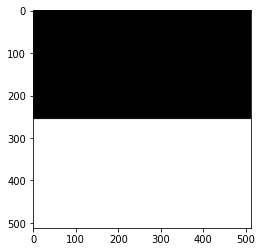

In [31]:
plt.imshow(mask.permute(1, 2, 0).cpu().numpy())

In [21]:
num_rows = 2
clusters = (generator.latent_to_image(prior.get_clusters())*127.5 + 128).detach().clamp(0, 255).to(torch.uint8)
grid_image = einops.rearrange(clusters.permute(0, 2, 3, 1).cpu().numpy(), "(n1 n2) h w c-> (n1 h) (n2 w) c", n1=num_rows)
plt.imsave("clusters2.png", grid_image)
# clusters.shape

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:39<00:00, 31.89s/it]


Saving image out10/cluster_prior57


In [35]:

init_t = 0.05
lr = 0.01
d = 10
mode = "mini_end"
num_img = 30
lamb = 2

# later TODO mem optimization -> mixed precision, gradient checkpointing, multiGPU 
projected_w_steps = projector.project_batched(
    num_img,
    6, # batch size -> depends on gpu
    learning_rate=lr,
    num_steps=100,
    diffusion_time_schedule=mode,
    num_diffusion_steps_per_step = d,
    # diffusion_step_size = s,
    mini_end_init_t = init_t,
    diffusion_magnitude_lambda = lamb,
    # optimizer_step = True,
    # prior_loss_weight = 0,
)

# save_image(projected_w_steps, projector, num_rows=5, outdir="out7", name="diff_prior3")

z, bpd = prior.ode_likelihood(projected_w_steps.detach()[:, :, None, :], eps=1e-6)
idxs = np.argsort(bpd.cpu().numpy())
ll_w_steps = projected_w_steps[idxs]
save_image(ll_w_steps, projector, num_rows=5, outdir="out9", name="diff_prior2")

# create_video(projected_w_steps, projector, num_rows=2, outdir="out6", name=f"diff11-initt{init_t}-lr{lr}-mode{mode}-innersteps{d}.mp4")

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 3/5 [01:33<01:02, 31.19s/it]

In [ ]:

init_t = 0.05
lr = 0.001
d = 10
mode = "mini_end"
num_img = 30
lamb = 2

# later TODO mem optimization -> mixed precision, gradient checkpointing, multiGPU 
projected_w_steps = projector.project_batched(
    num_img,
    6, # batch size -> depends on gpu
    learning_rate=lr,
    num_steps=100,
    diffusion_time_schedule=mode,
    num_diffusion_steps_per_step = d,
    # diffusion_step_size = s,
    mini_end_init_t = init_t,
    diffusion_magnitude_lambda = lamb,
    # optimizer_step = True,
    # prior_loss_weight = 0,
)

# save_image(projected_w_steps, projector, num_rows=5, outdir="out7", name="diff_prior3")

z, bpd = prior.ode_likelihood(projected_w_steps.detach()[:, :, None, :], eps=1e-6)
idxs = np.argsort(bpd.cpu().numpy())
ll_w_steps = projected_w_steps[idxs]
save_image(ll_w_steps, projector, num_rows=5, outdir="out9", name="diff_prior3")

# create_video(projected_w_steps, projector, num_rows=2, outdir="out6", name=f"diff11-initt{init_t}-lr{lr}-mode{mode}-innersteps{d}.mp4")

In [11]:
init_t = 0.01
s = 0.01
lr = 0.1
d = 10
mode = "constant"
num_img = 6

# later TODO mem optimization -> mixed precision, gradient checkpointing, multiGPU 
projected_w_steps = projector.project(
    learning_rate=lr,
    num_images=num_img,
    num_steps=100,
    diffusion_time_schedule=mode,
    num_diffusion_steps_per_step = d,
    diffusion_step_size = s,
    # mini_end_init_t = init_t,
)

create_video(projected_w_steps, projector, num_rows=2, outdir="out5", name=f"diff12-initt{init_t}-lr{lr}-mode{mode}-innersteps{d}.mp4")
del(projected_w_steps)

 51%|████████████████████████████████████████████████▍                                              | 51/100 [00:17<00:16,  2.97it/s]


KeyboardInterrupt: 

In [7]:
start_time = perf_counter()

stepsizes = [0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
time_schedules = ["linear", "constant", "mini"]
num_d_steps = [1, 10, 100, 1000]

for s in stepsizes:
    for mode in time_schedules:
        for d in num_d_steps:
            # later TODO mem optimization -> mixed precision, gradient checkpointing, multiGPU 
            projected_w_steps = projector.project(
                num_images=12,
                num_steps=100,
                diffusion_time_schedule=mode,
                num_diffusion_steps_per_step = d,
                diffusion_step_size = s
            )

            print (f'Elapsed: {(perf_counter()-start_time):.1f} s')
            create_video(projected_w_steps, projector, num_rows=3, outdir="out", name=f"diff-dfsteps{s}-mode{mode}-innersteps{d}.mp4")
            del(projected_w_steps)

start_time = perf_counter()

Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
step    1/100: prior_loss 0.00  task_loss 8.79 
step    2/100: prior_loss 0.00  task_loss 9.19 
step    3/100: prior_loss 0.00  task_loss 9.05 
step    4/100: prior_loss 0.00  task_loss 8.32 
step    5/100: prior_loss 0.00  task_loss 9.24 
step    6/100: prior_loss 0.00  task_loss 9.91 
step    7/100: prior_loss 0.00  task_loss 10.13
step    8/100: prior_loss 0.00  task_loss 9.69 
step    9/100: prior_loss 0.00  task_loss 9.51 
step   10/100: prior_loss 0.00  task_loss 10.13
step   11/100: prior_loss 0.00  task_loss 9.01 
step   12/100: prior_loss 0.00  task_loss 9.53 
step   13/100: prior_loss 0.00  task_loss 9.93 
step   14/100: prior_loss 0.00  task_loss 9.75 
step   15/100: prior_loss 0.00  task_loss 9.64 
step   16/100: prior_loss 0.00  task_loss 9.14 
step   17/100: prior_loss 0.00  task_loss 10.17
step   18/100: prior_loss 0.00  task_loss 9.07 
step   19/100: prior_loss 0.00  task_loss 9.53 
step   20/100: prior_loss 0.00  ta

In [8]:
start_time = perf_counter()

stepsizes = [0.00005, 0.00001, 0.000005, 0.000001]
time_schedules = ["linear", "constant", "mini"]
num_d_steps = [1, 10, 100, 1000]

for s in stepsizes:
    for mode in time_schedules:
        for d in num_d_steps:
            # later TODO mem optimization -> mixed precision, gradient checkpointing, multiGPU 
            projected_w_steps = projector.project(
                num_images=12,
                num_steps=100,
                diffusion_time_schedule=mode,
                num_diffusion_steps_per_step = d,
                diffusion_step_size = s
            )

            print (f'Elapsed: {(perf_counter()-start_time):.1f} s')
            create_video(projected_w_steps, projector, num_rows=3, outdir="out", name=f"diff-dfsteps{s}-mode{mode}-innersteps{d}.mp4")
            del(projected_w_steps)

start_time = perf_counter()


step    1/100: prior_loss 0.00  task_loss 7.91 
step    2/100: prior_loss 0.00  task_loss 8.08 
step    3/100: prior_loss 0.00  task_loss 7.83 
step    4/100: prior_loss 0.00  task_loss 7.52 
step    5/100: prior_loss 0.00  task_loss 7.37 
step    6/100: prior_loss 0.00  task_loss 7.08 
step    7/100: prior_loss 0.00  task_loss 6.90 
step    8/100: prior_loss 0.00  task_loss 6.70 
step    9/100: prior_loss 0.00  task_loss 6.57 
step   10/100: prior_loss 0.00  task_loss 6.42 
step   11/100: prior_loss 0.00  task_loss 6.30 
step   12/100: prior_loss 0.00  task_loss 6.17 
step   13/100: prior_loss 0.00  task_loss 6.05 
step   14/100: prior_loss 0.00  task_loss 5.93 
step   15/100: prior_loss 0.00  task_loss 5.79 
step   16/100: prior_loss 0.00  task_loss 5.69 
step   17/100: prior_loss 0.00  task_loss 5.58 
step   18/100: prior_loss 0.00  task_loss 5.50 
step   19/100: prior_loss 0.00  task_loss 5.43 
step   20/100: prior_loss 0.00  task_loss 5.35 
step   21/100: prior_loss 0.00  task_los

In [14]:
start_time = perf_counter()

# later TODO mem optimization -> mixed precision, gradient checkpointing, multiGPU 
projected_w_steps = projector.project(
    num_images=6,
    num_steps=100,
    diffusion_time_schedule="constant",
    num_diffusion_steps_per_step = 100,
)

print (f'Elapsed: {(perf_counter()-start_time):.1f} s')

create_video(projected_w_steps, projector, num_rows=3, outdir="out", name="diff_constant_100.mp4")
del(projected_w_steps)

step    1/100: prior_loss 0.00  task_loss 4.57 
step    2/100: prior_loss 0.00  task_loss 4.58 
step    3/100: prior_loss 0.00  task_loss 4.43 
step    4/100: prior_loss 0.00  task_loss 4.18 
step    5/100: prior_loss 0.00  task_loss 3.94 
step    6/100: prior_loss 0.00  task_loss 3.74 
step    7/100: prior_loss 0.00  task_loss 3.61 
step    8/100: prior_loss 0.00  task_loss 3.51 
step    9/100: prior_loss 0.00  task_loss 3.42 
step   10/100: prior_loss 0.00  task_loss 3.35 
step   11/100: prior_loss 0.00  task_loss 3.28 
step   12/100: prior_loss 0.00  task_loss 3.21 
step   13/100: prior_loss 0.00  task_loss 3.15 
step   14/100: prior_loss 0.00  task_loss 3.08 
step   15/100: prior_loss 0.00  task_loss 2.99 
step   16/100: prior_loss 0.00  task_loss 2.89 
step   17/100: prior_loss 0.00  task_loss 2.78 
step   18/100: prior_loss 0.00  task_loss 2.69 
step   19/100: prior_loss 0.00  task_loss 2.67 
step   20/100: prior_loss 0.00  task_loss 2.66 
step   21/100: prior_loss 0.00  task_los

In [15]:
start_time = perf_counter()

# later TODO mem optimization -> mixed precision, gradient checkpointing, multiGPU 
projected_w_steps = projector.project(
    num_images=6,
    num_steps=100,
    diffusion_time_schedule="linear",
    num_diffusion_steps_per_step=10,
)

print (f'Elapsed: {(perf_counter()-start_time):.1f} s')

create_video(projected_w_steps, projector, num_rows=3, outdir="out", name="diff_linear_10.mp4")
del(projected_w_steps)

step    1/100: prior_loss 0.00  task_loss 4.34 
step    2/100: prior_loss 0.00  task_loss 4.12 
step    3/100: prior_loss 0.00  task_loss 4.80 
step    4/100: prior_loss 0.00  task_loss 4.78 
step    5/100: prior_loss 0.00  task_loss 5.26 
step    6/100: prior_loss 0.00  task_loss 4.40 
step    7/100: prior_loss 0.00  task_loss 3.57 
step    8/100: prior_loss 0.00  task_loss 5.01 
step    9/100: prior_loss 0.00  task_loss 4.93 
step   10/100: prior_loss 0.00  task_loss 4.38 
step   11/100: prior_loss 0.00  task_loss 4.99 
step   12/100: prior_loss 0.00  task_loss 4.97 
step   13/100: prior_loss 0.00  task_loss 5.05 
step   14/100: prior_loss 0.00  task_loss 4.92 
step   15/100: prior_loss 0.00  task_loss 4.68 
step   16/100: prior_loss 0.00  task_loss 5.20 
step   17/100: prior_loss 0.00  task_loss 4.98 
step   18/100: prior_loss 0.00  task_loss 4.51 
step   19/100: prior_loss 0.00  task_loss 4.63 
step   20/100: prior_loss 0.00  task_loss 5.11 
step   21/100: prior_loss 0.00  task_los

In [4]:
gen = Generator(network_pkl, latent_space='w+', device=device)
prior = Prior(gen, device=device, prior_type='l2', regularize_w_l2=0.05)

blue_target = torch.cat((torch.zeros(2, 512, 512), 255*torch.ones(1, 512, 512)), 0)
task = Task(device=device, target=blue_target)
projector = Projector(gen, task, prior=prior, device=device)

# Optimize projection.
start_time = perf_counter()

# later TODO mem optimization -> mixed precision, gradient checkpointing, multiGPU 
projected_w_steps = projector.project(
    num_images=6,
    num_steps=100,
)

print (f'Elapsed: {(perf_counter()-start_time):.1f} s')

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/oleksiiv/anaconda3/envs/ganenv8/lib/python3.9/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)


Done.
step    1/100: prior_loss 1669.74 task_loss 4.70 
step    2/100: prior_loss 1669.74 task_loss 4.70 
step    3/100: prior_loss 1617.49 task_loss 4.69 
step    4/100: prior_loss 1518.80 task_loss 4.69 
step    5/100: prior_loss 1384.58 task_loss 4.69 
step    6/100: prior_loss 1228.99 task_loss 4.68 
step    7/100: prior_loss 1066.99 task_loss 4.66 
step    8/100: prior_loss 934.77 task_loss 4.67 
step    9/100: prior_loss 825.99 task_loss 4.66 
step   10/100: prior_loss 735.29 task_loss 4.66 
step   11/100: prior_loss 658.44 task_loss 4.67 
step   12/100: prior_loss 592.26 task_loss 4.66 
step   13/100: prior_loss 534.34 task_loss 4.66 
step   14/100: prior_loss 483.01 task_loss 4.66 
step   15/100: prior_loss 437.08 task_loss 4.65 
step   16/100: prior_loss 395.74 task_loss 4.63 
step   17/100: prior_loss 358.43 task_loss 4.60 
step   18/100: prior_loss 324.71 task_loss 4.57 
step   19/100: prior_loss 294.24 task_loss 4.54 
step   20/100: prior_loss 266.70 task_loss 4.51 
step   

In [8]:
gen = Generator(network_pkl, latent_space='w+', device=device)
prior = Prior(gen, device=device, prior_type='cluster', regularize_cluster_weight=0.01)

blue_target = torch.cat((torch.zeros(2, 512, 512), 255*torch.ones(1, 512, 512)), 0)
task = Task(device=device, target=blue_target)
projector = Projector(gen, task, prior=prior, device=device)

# Optimize projection.
start_time = perf_counter()

# later TODO mem optimization -> mixed precision, gradient checkpointing, multiGPU 
projected_w_steps = projector.project(
    num_images=6,
    num_steps=100,
)

print (f'Elapsed: {(perf_counter()-start_time):.1f} s')

running k-means on cuda..


[running kmeans]: 58it [00:59,  1.02s/it, center_shift=0.000000, iteration=58, tol=0.000100]


step    1/100: prior_loss 221.40 task_loss 4.72 
step    2/100: prior_loss 221.40 task_loss 4.72 
step    3/100: prior_loss 212.69 task_loss 4.69 
step    4/100: prior_loss 196.43 task_loss 4.61 
step    5/100: prior_loss 174.78 task_loss 4.42 
step    6/100: prior_loss 150.44 task_loss 4.26 
step    7/100: prior_loss 126.03 task_loss 4.12 
step    8/100: prior_loss 106.88 task_loss 4.05 
step    9/100: prior_loss 91.67 task_loss 3.96 
step   10/100: prior_loss 79.37 task_loss 3.89 
step   11/100: prior_loss 69.20 task_loss 3.83 
step   12/100: prior_loss 60.64 task_loss 3.79 
step   13/100: prior_loss 53.32 task_loss 3.74 
step   14/100: prior_loss 46.98 task_loss 3.70 
step   15/100: prior_loss 41.44 task_loss 3.66 
step   16/100: prior_loss 36.58 task_loss 3.63 
step   17/100: prior_loss 32.31 task_loss 3.61 
step   18/100: prior_loss 28.57 task_loss 3.58 
step   19/100: prior_loss 25.29 task_loss 3.56 
step   20/100: prior_loss 22.41 task_loss 3.54 
step   21/100: prior_loss 19.89 

In [35]:
gen = Generator(network_pkl, latent_space='z+', device=device)
task = Task(device=device, task_type = 'clip_text', target_str = 'racecar')
prior = Prior(gen, device=device, prior_type='cluster', regularize_cluster_weight=1.5, cluster_samples=2000)
projector = Projector(gen, task, prior=prior, device=device)

# Optimize projection.
start_time = perf_counter()

# later TODO mem optimization -> mixed precision, gradient checkpointing, multiGPU 
projected_w_steps = projector.project(
    num_images=12,
    num_steps=100,
)

print (f'Elapsed: {(perf_counter()-start_time):.1f} s')

running k-means on cuda..


[running kmeans]: 108it [00:21,  5.02it/s, center_shift=0.000000, iteration=108, tol=0.000100]


step    1/100: prior_loss 141760.52 task_loss 9.03 
step    2/100: prior_loss 141760.52 task_loss 8.99 
step    3/100: prior_loss 137204.35 task_loss 9.02 
step    4/100: prior_loss 128445.52 task_loss 8.98 
step    5/100: prior_loss 116174.78 task_loss 9.00 
step    6/100: prior_loss 101363.99 task_loss 9.05 
step    7/100: prior_loss 85179.39 task_loss 9.01 
step    8/100: prior_loss 71358.27 task_loss 8.95 
step    9/100: prior_loss 59644.76 task_loss 8.92 
step   10/100: prior_loss 49784.50 task_loss 8.96 
step   11/100: prior_loss 41538.85 task_loss 9.02 
step   12/100: prior_loss 34685.85 task_loss 9.00 
step   13/100: prior_loss 29021.61 task_loss 9.05 
step   14/100: prior_loss 24363.93 task_loss 9.06 
step   15/100: prior_loss 20549.63 task_loss 9.02 
step   16/100: prior_loss 17436.30 task_loss 9.09 
step   17/100: prior_loss 14900.57 task_loss 9.09 
step   18/100: prior_loss 12835.36 task_loss 9.05 
step   19/100: prior_loss 11151.67 task_loss 9.05 
step   20/100: prior_loss

In [9]:
gen = Generator(network_pkl, latent_space='z+', device=device)
# prior = Prior(gen, device=device, prior_type='cluster', regularize_cluster_weight=1.5, cluster_samples=2000)
prior = None
blue_target = torch.cat((torch.zeros(2, 512, 512), 255*torch.ones(1, 512, 512)), 0)
task = Task(device=device, target=blue_target)
projector = Projector(gen, task, prior=prior, device=device)

# Optimize projection.
start_time = perf_counter()

# later TODO mem optimization -> mixed precision, gradient checkpointing, multiGPU 
projected_w_steps = projector.project(
    num_images=12,
    num_steps=100,
)

print (f'Elapsed: {(perf_counter()-start_time):.1f} s')

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
step    1/100: prior_loss 0.00  task_loss 9.26 
step    2/100: prior_loss 0.00  task_loss 9.27 
step    3/100: prior_loss 0.00  task_loss 8.56 
step    4/100: prior_loss 0.00  task_loss 8.01 
step    5/100: prior_loss 0.00  task_loss 7.51 
step    6/100: prior_loss 0.00  task_loss 7.08 
step    7/100: prior_loss 0.00  task_loss 6.70 
step    8/100: prior_loss 0.00  task_loss 6.33 
step    9/100: prior_loss 0.00  task_loss 5.96 
step   10/100: prior_loss 0.00  task_loss 5.61 
step   11/100: prior_loss 0.00  task_loss 5.36 
step   12/100: prior_loss 0.00  task_loss 5.17 
step   13/100: prior_loss 0.00  task_loss 4.97 
step   14/100: prior_loss 0.00  task_loss 4.78 
step   15/100: prior_loss 0.00  task_loss 4.56 
step   16/100: prior_loss 0.00  task_loss 4.41 
step   17/100: prior_loss 0.00  task_loss 4.26 
step   18/100: prior_loss 0.00  task_loss 4.14 
step   19/100: prior_loss 0.0

In [7]:
outdir

'out'

Saving optimization progress video "out/test.mp4"


In [ ]:
# Save final projected frame and W vector.
target_pil.save(f'{outdir}/target.png')
projected_w = projected_w_steps[-1]
synth_image = G.synthesis(projected_w.unsqueeze(0), noise_mode='none')
synth_image = (synth_image + 1) * (255/2)
synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
PIL.Image.fromarray(synth_image, 'RGB').save(f'{outdir}/projblue.png')
np.savez(f'{outdir}/projected_wblue.npz', w=projected_w.unsqueeze(0).cpu().numpy())

In [13]:
from __future__ import annotations
import wandb
import argparse

import imageio
import torch
from projector import *
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import numpy as np
from score import ScoreTrainer
import os
import matplotlib.pyplot as plt
import einops

In [26]:
class Args:
    hidden_dim = 4000
    num_hidden = 7
    hidden_w = 1
    hidden_h = 512
    normalize = True
    network_pkl = "https://nvlabs-fi-cdn.nvidia.com/stylegan2/networks/stylegan2-car-config-f.pkl"
    latent_space = 'w'
    # batch_size = 64
    # lr = 1e-4
    # num_epochs = 500
    data = 'gan'
    sigma = 25
    max_t = 1

In [27]:
device = 'cuda'

args = Args

generator = Generator(args.network_pkl, device=device, latent_space=args.latent_space)

trainer = ScoreTrainer(args, device=device, sigma=args.sigma, im_width=1, im_height=512)
trainer.load_network("/home/oleksiiv/logs/ominous-wraith-125/epoch_2000_ckpt.pth")
# trainer.train(args.data, args.num_epochs, args.batch_size, args.lr, generator, max_t=args.max_t)

Using group norm group size = 32.


In [33]:
num_samples = 4 ** 2
num_steps = 100

samples = trainer.pc_sampler_seq(num_steps=num_steps, batch_size=num_samples)[:, :, 0] # 100, 16, 1, 1, 512 -> 100, 16, 1, 512
outdir = "out8"

num_rows = 4
os.makedirs(outdir, exist_ok=True)
with torch.no_grad():
    video = imageio.get_writer(f'{outdir}/gan_w_test.mp4', mode='I', fps=25, codec='libx264', bitrate='16M')
    print (f'Saving optimization progress video "{outdir}/gan_w_test.mp4"')
    for i in range(num_steps):
        sub_samples = samples[i]
        ims = (generator.latent_to_image(sub_samples)+1)*(255/2)
        ims = ims.clamp(0, 255).permute(0, 2, 3, 1).to(torch.uint8).cpu().numpy()
        grid_image = einops.rearrange(ims, "(n1 n2) h w c-> (n1 h) (n2 w) c", n1=num_rows)
        video.append_data(grid_image)
        # video.append_data(np.concatenate([target_uint8, synth_image], axis=1))
    video.close()

name = "diff_samples"
print (f'Saving image {outdir}/{name}')
with torch.no_grad():
    synth_image = generator.latent_to_image(samples[-1])
    synth_image = (synth_image + 1) * (255/2)
    synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8).cpu().numpy()
    grid_image = einops.rearrange(synth_image, "(n1 n2) h w c-> (n1 h) (n2 w) c", n1=num_rows)
    plt.imsave(f'{outdir}/{name}.png', grid_image)

Saving optimization progress video "out8/gan_w_test.mp4"
Saving image out8/diff_samples


In [44]:
num_samples = 4 ** 2
num_steps = 1000

samples = trainer.pc_sampler(num_steps=num_steps, batch_size=num_samples)[:, 0] # 100, 16, 1, 1, 512 -> 100, 16, 1, 512
outdir = "out8"

num_rows = 4

name = "diff_samples2"
print (f'Saving image {outdir}/{name}')
print(samples.shape)
with torch.no_grad():
    synth_image = generator.latent_to_image(samples)
    synth_image = (synth_image + 1) * (255/2)
    synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8).cpu().numpy()
    grid_image = einops.rearrange(synth_image, "(n1 n2) h w c-> (n1 h) (n2 w) c", n1=num_rows)
    plt.imsave(f'{outdir}/{name}.png', grid_image)

Saving image out8/diff_samples2
torch.Size([16, 1, 512])


In [16]:
samples = trainer.pc_sampler(num_steps=num_steps, batch_size=num_samples)
ims = generator.latent_to_image(samples[:,0])*255
ims = ims.clamp(0, 255).permute(0, 2, 3, 1).to(torch.uint8).cpu().numpy()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 322.32it/s]


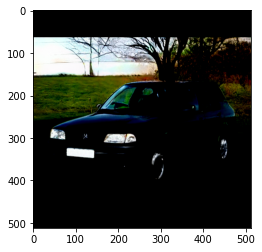

In [17]:
from matplotlib import pyplot as plt
plt.imshow(ims[0])
plt.show()

In [15]:
ims[0].max()

1

In [1]:
!nvidia-smi

Mon Oct 11 14:14:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 460.27.04    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 8000     On   | 00000000:41:00.0 Off |                  Off |
| 33%   38C    P0    86W / 260W |      0MiB / 48601MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------